In [62]:
!pip install transformers

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from torch.nn.functional import cross_entropy, softmax
from torch import tensor, save, device
from torch.optim import AdamW

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Разобьем данные на выборки, определим константы и гиперпараметры
Здесь train_len - доля тестовой выборки взятой из train.tsv, а test_len - доля выборки для подсчета метрик, в случае если данные нужно разметить test_len = 1e-2

In [64]:
train_len = 0.9
test_len = 1e-2

count_metric = False
mark_test = True

batch_size = 512
epoch = 4
learning_rate = 5e-4

data = pd.read_csv('train.tsv', sep='\t')
data = data.sample(frac=1, random_state=42)
train, test_and_valid = train_test_split(data, test_size=(1. - train_len), train_size=train_len)
test, valid = train_test_split(test_and_valid, test_size=(1. - test_len), train_size=test_len)

length = len(train)
num_of_batches = (length + batch_size - 1) // batch_size

# Загрузим модель и поместим ее на видеокарту

In [65]:
model_name = 'cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
optimizer = AdamW(model.parameters(), lr=learning_rate)

try:
  dev = device('cuda:0')
except Exception:
  dev = device('cpu:0')

model.to(dev)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elemen

# Код для обучения модели

In [66]:
def train_model(dataset):
  
  losses = []

  model.train()
  for _ in range(epoch):

    print(f'Epoch number {_+1}:')
    dataset = dataset.sample(frac=1, random_state=7)
    titles = dataset['title']
    labels = dataset['is_fake']

    batches = [[] for _ in range(num_of_batches)]
    true_score = [[] for _ in range(num_of_batches)]

    for idx, arg in enumerate(zip(titles, labels)):

      def get_label(n):
        label = [0., 0.]
        label[n] = 1.
        return label

      text, label = arg
      batches[idx % num_of_batches].append(text)
      true_score[idx % num_of_batches].append(get_label(label))

    print(f'Batches ready, start training:')

    batches = [tokenizer(batch, truncation=True, padding=True, return_tensors='pt') for batch in batches]
    for idx, arg in enumerate(zip(batches, true_score)):
      batch, label = arg

      output = model(batch['input_ids'].to(dev), batch['attention_mask'].to(dev))
      label = tensor(label).to(dev)
      loss = cross_entropy(output.logits, label)

      loss.backward()
      optimizer.step()
      model.zero_grad()

      losses.append(float(loss))

      print(f'Epoch: {_ + 1}, loss = {loss}, processing {100*idx//num_of_batches}% of batches')

  return losses

Epoch number 1:
Batches ready, start training:
Epoch: 1, loss = 0.6914331912994385, processing 0% of batches
Epoch: 1, loss = 0.6443195939064026, processing 9% of batches
Epoch: 1, loss = 0.5714970827102661, processing 18% of batches
Epoch: 1, loss = 0.5297219157218933, processing 27% of batches
Epoch: 1, loss = 0.42489275336265564, processing 36% of batches
Epoch: 1, loss = 0.3775339722633362, processing 45% of batches
Epoch: 1, loss = 0.3764486014842987, processing 54% of batches
Epoch: 1, loss = 0.3591556251049042, processing 63% of batches
Epoch: 1, loss = 0.3504996597766876, processing 72% of batches
Epoch: 1, loss = 0.316470205783844, processing 81% of batches
Epoch: 1, loss = 0.3338571786880493, processing 90% of batches
Epoch number 2:
Batches ready, start training:
Epoch: 2, loss = 0.24032706022262573, processing 0% of batches
Epoch: 2, loss = 0.22453562915325165, processing 9% of batches
Epoch: 2, loss = 0.20655035972595215, processing 18% of batches
Epoch: 2, loss = 0.176445

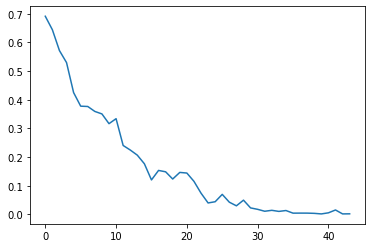

In [67]:
losses = train_model(train)

plt.plot(losses)
plt.show()

In [68]:
def mark(titles, labels):
    model.to('cpu:0')
    pred, true = [], []
    for text, label in zip(titles, labels):
        token = tokenizer(text, truncation=True, padding=True, return_tensors='pt')
        ids, mask = token['input_ids'], token['attention_mask']

        label = tensor(label).unsqueeze(0)
        output = model(ids, attention_mask=mask)

        pred.append(float(softmax(output.logits, dim=1)[0][1]))
        true.append(int(label))
    return pred, true

def print_scores(pred, true, treshold):
    pred = list(map(lambda x: int(x > treshold), pred))

    f1 = f1_score(true, pred)
    print(f'F1_score for this model: {f1}')
    acc = accuracy_score(true, pred)
    print(f'Accuracy score for this model: {acc}')
    roc_auc = roc_auc_score(true, pred)
    print(f'ROC-AUC score for this model: {roc_auc}')

def validate(pred, true):
    precision, recall, trash = precision_recall_curve(true, pred)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()

    best_thold = 0
    best_ans = 0
    for thold in np.arange(0, 1, 0.05, dtype=float):
        custom_pred = [int(i > thold) for i in pred]
        f1 = f1_score(true, custom_pred)
        if f1 > best_ans:
            best_ans = f1
            best_thold = thold
    return best_thold

# Провалидируем и если нужно посмотрим на значения метрик

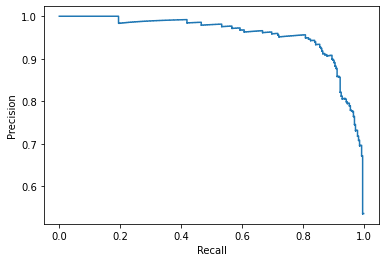

0.05


In [69]:
model.eval()

titles_v = valid['title']
labels_v = valid['is_fake']
pred_v, true_v = mark(titles_v, labels_v)
threshold = validate(pred_v, true_v)
print(threshold)

if count_metric > 0:
    titles_test = test['title']
    labels_test = test['is_fake']
    pred, true = mark(titles_test, labels_test)
    print_scores(pred, true, 0.5)

# Определим функции для разметки тестовой выборки

In [70]:
def get_pred(text, threshold):
  token = tokenizer(text, truncation=True, padding=True, return_tensors='pt')
  ids, mask = token['input_ids'], token['attention_mask']
  output = model(ids, attention_mask=mask)
  label = float(softmax(output.logits, dim=1)[0][1]) > threshold
  return int(label)

def mark_test_data(test_data):
    for i in range(len(test_data)):
        test_data['is_fake'][i] = get_pred(test_data['title'][i], threshold)
    test_data.to_csv('prediction.tsv', sep='\t')

In [71]:
if mark_test:
    test_data = pd.read_csv('test.tsv', sep='\t')
    mark_test_data(test_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
